This is a notebook to generate example bikeability plots

In [1]:
import cenpy
import osmnx
import networkx as nx
import pandas as pd
import pickle
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [2]:
%load_ext autoreload
%autoreload 2
import dem_functions as df
import bikeability_functions as bf

In [3]:
plt.style.use('seaborn')

C:\Users\kyan\AppData\Local\Temp\ipykernel_25552\240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Load example data (SF)

In [4]:
place = 'San Francisco, CA'
file_name = 'data/V2_SF_coarse_graph_cluster'

In [5]:
with open(file_name, 'rb') as f:
    G = pickle.load(f)

In [6]:
# incorporate discomfort function
G=bf.add_discomfort(G,scale='linear')

## Pareto curve for OD pair

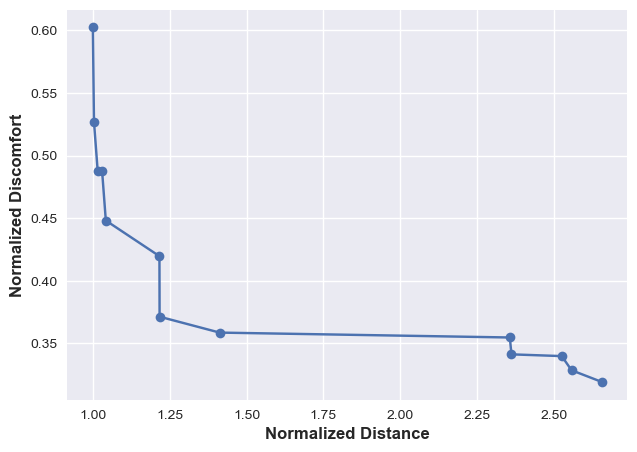

In [7]:
sp = bf.compute_pareto_fronts(G,'035202')
length_risk_curve = sp.get('012000')

rel_dist=np.array(length_risk_curve.keys())/min(length_risk_curve.keys())
rel_risk=np.array(length_risk_curve.values())/min(length_risk_curve.keys())

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(rel_dist, rel_risk, marker='o', linestyle='solid')
ax.set_xlabel('Normalized Distance',fontsize=12,fontweight='semibold')
ax.set_ylabel('Normalized Discomfort',fontsize=12,fontweight='semibold')
plt.subplots_adjust(bottom=0.1,left=0.1)
fig.savefig('figures/Pareto_curve.png',facecolor='white',dpi=300)

## Network-wide bikeability curve

In [9]:
all_curves = bf.compute_bikeability_curves(G,G.nodes(),dest='all')

betas=np.linspace(0.01,10,200)
user_dict_all=bf.network_wide_bikeability_curve(betas, all_curves)

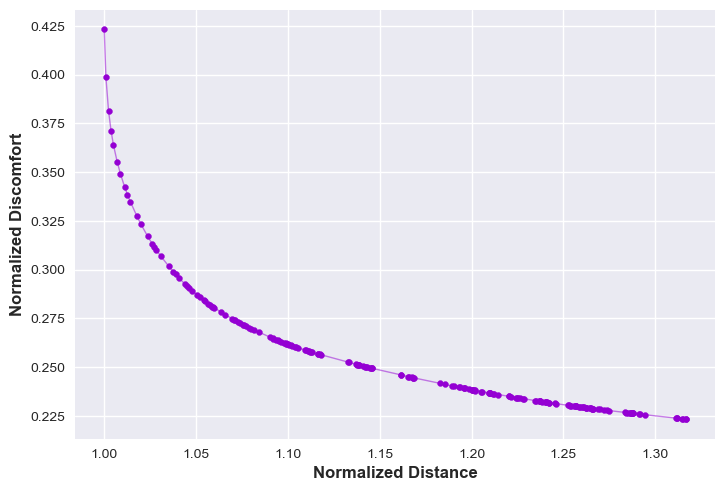

In [83]:
fig,ax=plt.subplots()
ax.plot(np.array([data[1] for _,data in user_dict_all.items()]),
                 np.array([data[2] for _,data in user_dict_all.items()]),linewidth=1,color='darkviolet',alpha=0.5)
ax.scatter(np.array([data[1] for _,data in user_dict_all.items()]),
                 np.array([data[2] for _,data in user_dict_all.items()]),s=18,c='darkviolet')
ax.set_xlabel('Normalized Distance',fontsize=12,fontweight='semibold')
ax.set_ylabel('Normalized Discomfort',fontsize=12,fontweight='semibold')
plt.subplots_adjust(bottom=0.1,left=0.1)
fig.savefig('figures/network_curve.png',facecolor='white',dpi=300)

## "Elbow" locator method

In [11]:
acs_vars = {'B02001_001E':'total_pop','B02001_002E':'total_pop_white',
            'B19013_001E':'median_hh_income','B06012_002E':'below_poverty'}
dem = df.get_dem(place,acs_vars)

Matched: San Francisco, CA to San Francisco city within layer Incorporated Places


C:\Users\kyan3\Documents\Thesis\dem_functions.py:8: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [13]:
keys = ['median_hh_income']
quant_of_int = df.all_quants(keys,dem)
income_quant_thres = df.quant_thres(dem,'median_hh_income')

In [14]:
# test to compare bikeability curves for upper/lower quintiles of median hh income
income_low = bf.compute_bikeability_curves(G,quant_of_int['median_hh_income'][0])
income_high = bf.compute_bikeability_curves(G,quant_of_int['median_hh_income'][1])

In [15]:
user_dict_1=bf.network_wide_bikeability_curve(betas, income_low)
user_dict_2=bf.network_wide_bikeability_curve(betas, income_high)

In [19]:
x_low = np.array(list(user_dict_1.values()))[:,1]
y_low = np.array(list(user_dict_1.values()))[:,2]

x_high = np.array(list(user_dict_2.values()))[:,1]
y_high = np.array(list(user_dict_2.values()))[:,2]

In [22]:
kneedle_low = KneeLocator(x_low, y_low, S=1.0, curve='convex', direction="decreasing")
kneedle_high = KneeLocator(x_high, y_high, S=1.0, curve='convex', direction="decreasing")

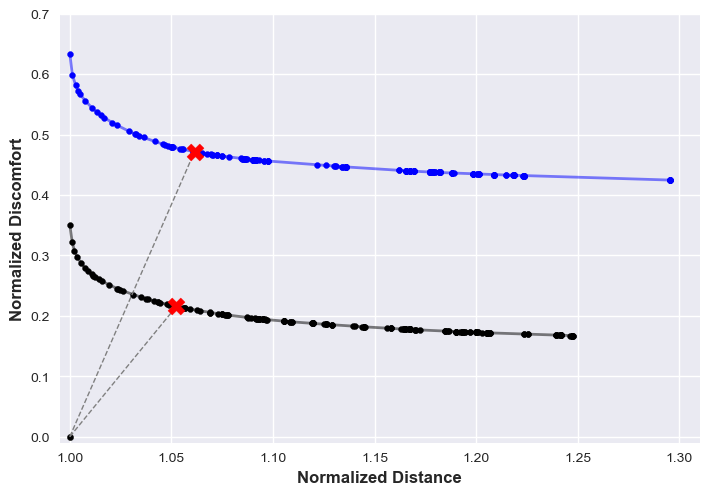

In [62]:
fig,ax=plt.subplots()
ax.plot(x_low,y_low,linewidth=2,color='blue',alpha=0.5)
ax.scatter(x_low,y_low,s=18,c='blue')
ax.scatter(kneedle_low.elbow,kneedle_low.elbow_y,c='red',marker='X',s=150,zorder=10)

ax.plot(x_high,y_high,linewidth=2,color='black',alpha=0.5)
ax.scatter(x_high,y_high,s=18,c='black')
ax.scatter(kneedle_high.elbow,kneedle_high.elbow_y,c='red',marker='X',s=150,zorder=10)

ax.plot([1,kneedle_low.elbow],[0,kneedle_low.elbow_y],linestyle='dashed',linewidth=1,color='gray')
ax.plot([1,kneedle_high.elbow],[0,kneedle_high.elbow_y],linestyle='dashed',linewidth=1,color='gray')
ax.scatter(1,0,c='black',s=20)

ax.set_xlim([0.995,1.31])
ax.set_ylim([-0.01,0.7])

ax.set_xlabel('Normalized Distance',fontsize=12,fontweight='semibold')
ax.set_ylabel('Normalized Discomfort',fontsize=12,fontweight='semibold')
plt.subplots_adjust(bottom=0.1,left=0.1)
fig.savefig('figures/elbow.png',facecolor='white',dpi=300)

## Network-wide bikeability: city comparison

In [63]:
G_SF = bf.load_graph('data/V2_SF_coarse_graph_cluster')
G_Philly = bf.load_graph('data/V2_Philly_coarse_graph_cluster')
G_Detroit = bf.load_graph('data/V2_Detroit_coarse_graph_cluster')

In [64]:
betas=np.linspace(0.01,10,200)

In [66]:
curves_SF = bf.compute_bikeability_curves(G_SF,G_SF.nodes(),dest='all')
user_dict_SF = bf.network_wide_bikeability_curve(betas, curves_SF)

In [67]:
curves_Philly = bf.compute_bikeability_curves(G_Philly,G_Philly.nodes(),dest='all')
user_dict_Philly = bf.network_wide_bikeability_curve(betas, curves_Philly)

In [68]:
curves_Detroit = bf.compute_bikeability_curves(G_Detroit,G_Detroit.nodes(),dest='all')
user_dict_Detroit = bf.network_wide_bikeability_curve(betas, curves_Detroit)

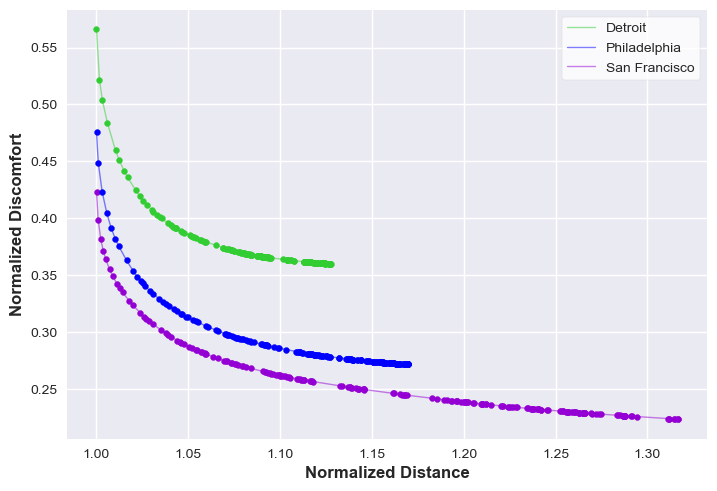

In [99]:
fig,ax=plt.subplots()
line1, = ax.plot(np.array([data[1] for _,data in user_dict_SF.items()]),
                 np.array([data[2] for _,data in user_dict_SF.items()]),
                linewidth=1,color='darkviolet',alpha=0.5,label='San Francisco')
ax.scatter(np.array([data[1] for _,data in user_dict_SF.items()]),
                 np.array([data[2] for _,data in user_dict_SF.items()]),s=18,c='darkviolet')

line2, =ax.plot(np.array([data[1] for _,data in user_dict_Philly.items()]),
                 np.array([data[2] for _,data in user_dict_Philly.items()]),
               linewidth=1,color='blue',alpha=0.5,label='Philadelphia')
ax.scatter(np.array([data[1] for _,data in user_dict_Philly.items()]),
                 np.array([data[2] for _,data in user_dict_Philly.items()]),s=18,c='blue')

line3, = ax.plot(np.array([data[1] for _,data in user_dict_Detroit.items()]),
                 np.array([data[2] for _,data in user_dict_Detroit.items()]),
                linewidth=1,color='limegreen',alpha=0.5,label='Detroit')
ax.scatter(np.array([data[1] for _,data in user_dict_Detroit.items()]),
                 np.array([data[2] for _,data in user_dict_Detroit.items()]),s=18,c='limegreen')

ax.legend(handles=[line3,line2,line1],frameon=True,facecolor='white')

ax.set_xlabel('Normalized Distance',fontsize=12,fontweight='semibold')
ax.set_ylabel('Normalized Discomfort',fontsize=12,fontweight='semibold')
plt.subplots_adjust(bottom=0.1,left=0.1)

fig.savefig('figures/city_network_curves.png',facecolor='white',dpi=300)

In [95]:
bf.calc_elbow(user_dict_SF)

3.4818796818367885

In [96]:
bf.calc_elbow(user_dict_Philly)

3.0416040205323225

In [97]:
bf.calc_elbow(user_dict_Detroit)

2.4501304038820795